In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from copy import deepcopy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Get calculated map

In [41]:
fname = 'map_no_dephasing.csv'
df = pd.read_csv('maps_to_learn/'+fname).drop(['Unnamed: 0'], axis=1)

In [42]:
df

,mu_old,sig_old,t_opt,mu0,sig0,mu1,sig1
0,0.0,0.001000,1745.745744,0.000000,0.000674,0.001256,0.000521
1,0.0,0.001013,1724.138836,0.000000,0.000683,0.001271,0.000527
2,0.0,0.001025,1702.799355,0.000000,0.000691,0.001288,0.000534
3,0.0,0.001038,1681.723990,0.000000,0.000700,0.001304,0.000541
4,0.0,0.001051,1660.909472,0.000000,0.000709,0.001320,0.000548
...,...,...,...,...,...,...,...
34549,1.0,0.469814,1.763001,0.687799,0.379834,1.239589,0.378771
34550,1.0,0.475702,1.741180,0.688348,0.383676,1.246953,0.382939
34551,1.0,0.481663,1.761572,0.678476,0.389640,1.248390,0.385380
34552,1.0,0.487700,1.739769,0.678972,0.393361,1.255980,0.389631


In [45]:
df.to_numpy().shape

(34554, 7)

### Plot targets

In [46]:
# Create the grid of inputs/outputs to the map and set all points where we don't have data to NaN

mu_old = np.sort(np.unique(df['mu_old'].to_numpy()))
sig_old = np.sort(np.unique(df['sig_old'].to_numpy()))

N = mu_old.shape[0]
M = sig_old.shape[0]

fmap = np.empty((N,M,7))
fmap[:] = np.nan

for row in df.to_numpy():
    i = np.argwhere(mu_old == row[0])[0]
    j = np.argwhere(sig_old == row[1])[0]
    fmap[i,j,:] = row

<IPython.core.display.Javascript object>


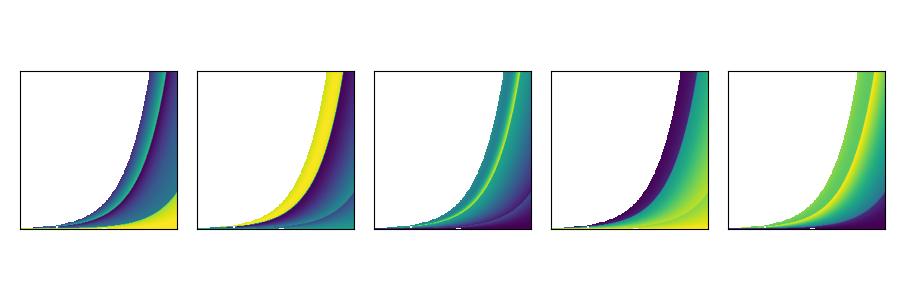

In [60]:
# Plot target maps

fig, axs  = plt.subplots(1, 5, figsize=(9,3))
axs[0].imshow(fmap[:,:,2]*fmap[:,:,1]/2, aspect='auto', origin='lower')
axs[0].set_box_aspect(1)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow((fmap[:,:,3]-fmap[:,:,0])/fmap[:,:,1], aspect='auto', origin='lower')
axs[1].set_box_aspect(1)
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(fmap[:,:,4]/fmap[:,:,1], aspect='auto', origin='lower')
axs[2].set_box_aspect(1)
axs[2].set_xticks([])
axs[2].set_yticks([])

axs[3].imshow((fmap[:,:,5]-fmap[:,:,0])/fmap[:,:,1], aspect='auto', origin='lower')
axs[3].set_box_aspect(1)
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[4].imshow(fmap[:,:,6]/fmap[:,:,1], aspect='auto', origin='lower')
axs[4].set_box_aspect(1)
axs[4].set_xticks([])
axs[4].set_yticks([])

fig.tight_layout()

fig.show()

## Train NN on (scaled) targets

In [61]:
targets = df[['t_opt', 'mu0', 'sig0', 'mu1', 'sig1']].to_numpy()


# Scale outputs
targets[:,0] *= df['sig_old'].to_numpy()/2
targets[:,1] = (targets[:,1] - df['mu_old'].to_numpy())/df['sig_old'].to_numpy()
targets[:,3] = (targets[:,3] - df['mu_old'].to_numpy())/df['sig_old'].to_numpy()
targets[:,2] /= df['sig_old'].to_numpy()
targets[:,4] /= df['sig_old'].to_numpy()


## HYPERPARAMETERS ##
nodes = [20, 20, 20]
activations = ['tanh', 'tanh', 'tanh']
lr = 0.0001


# Define model with 2 inputs
model = keras.Sequential([tf.keras.layers.Input(shape=(2,))])

# Add hidden layers
for i in range(len(nodes)):
    model.add(layers.Dense(nodes[i], activation=activations[i]))

# Add output layer for 5 outputs
model.add(layers.Dense(5))

# Compile model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

# Train model
history = model.fit(
    df[['mu_old', 'sig_old']].to_numpy(),
    targets,
    validation_split = 0.1,
    verbose=0, 
    epochs=100000, 
    batch_size=1000)

model.save('hybrid_map_no_dephasing')

INFO:tensorflow:Assets written to: hybrid_map_no_dephasing/assets


In [80]:
# Check model predictions at the training data inputs to see if it interpolates well
domain = np.array([[x, y] for x in mu_old for y in sig_old])
domain[domain[:,0] > 2*np.pi*domain[:,1]] = np.nan
NN_map = model(domain).numpy().reshape(N,M,5)

<IPython.core.display.Javascript object>


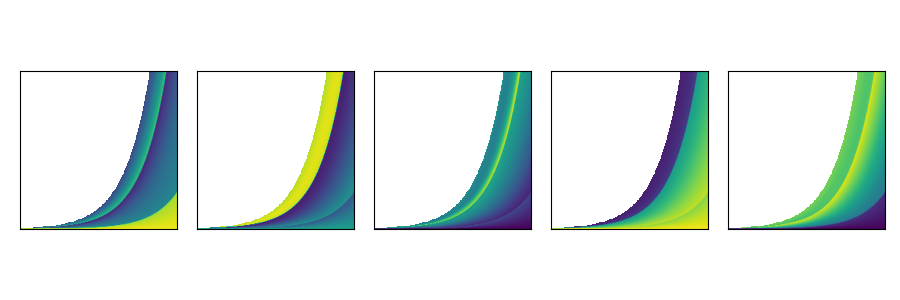

In [82]:
fig, axs  = plt.subplots(1, 5, figsize=(9,3))
axs[0].imshow(NN_map[:,:,0], aspect='auto', origin='lower')
axs[0].set_box_aspect(1)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(NN_map[:,:,1], aspect='auto', origin='lower')
axs[1].set_box_aspect(1)
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(NN_map[:,:,2], aspect='auto', origin='lower')
axs[2].set_box_aspect(1)
axs[2].set_xticks([])
axs[2].set_yticks([])

axs[3].imshow(NN_map[:,:,3], aspect='auto', origin='lower')
axs[3].set_box_aspect(1)
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[4].imshow(NN_map[:,:,4], aspect='auto', origin='lower')
axs[4].set_box_aspect(1)
axs[4].set_xticks([])
axs[4].set_yticks([])

fig.tight_layout()

fig.show()